In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab"

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])

In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input dataset for lgbm
train_dset = lgb.Dataset(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
    free_raw_data=True
)
valid_dset = lgb.Dataset(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
    free_raw_data=True
)

In [7]:
import gc
gc.collect()

47

***
## Bayesian Optimization

In [8]:
default_params = {
    'boosting': 'dart',
    'linear_tree':True,
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'max_bin':511,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e8),
    'feature_pre_filter' : False,
}

In [9]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [10]:
def objective(trial):    
    sampled_params = dict(
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.1, 0.4, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.8, 1.0, 0.05),
        lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-4, 1e1),
        lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-4, 1e1),
        linear_lambda = trial.suggest_float("linear_lambda", 0., 500.),
        path_smooth = trial.suggest_float("path_smooth", 0., 50.),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1000, 5000, 100),
        # dart params
        drop_rate = trial.suggest_discrete_uniform("drop_rate", 0.05, 0.2, 0.01),
        max_drop = trial.suggest_int("max_drop", 10, 100, 10),
        skip_drop = trial.suggest_discrete_uniform("skip_drop", 0.25, 0.75, 0.05),  
    )
    model_params = {**default_params, **sampled_params}
        
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=trial.suggest_int("num_iterations", 500, 2000, 100),
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(features_valid)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
do_optimize = False

study = optuna.create_study(
    study_name="lgbm-linear-dart",
    direction='maximize',
    storage='sqlite:///lgbm-linear-dart.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=172800, # 48-hrs
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-03-15 02:13:36,895] Using an existing study with name 'lgbm-linear-dart' instead of creating a new one.


In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_drop_rate,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_linear_lambda,params_max_drop,params_min_data_in_leaf,params_num_iterations,params_path_smooth,params_skip_drop,state
125,125,0.135720,2022-03-14 22:06:14.268304,2022-03-14 22:15:35.280725,0 days 00:09:21.012421,1.00,0.12,0.15,9.088905,0.187480,269.307659,10,2400,1800,6.671261,0.75,COMPLETE
27,27,0.135699,2022-03-13 13:10:20.988200,2022-03-13 13:21:02.626848,0 days 00:10:41.638648,0.95,0.11,0.20,0.000364,3.747241,310.487160,10,1900,1800,15.881885,0.75,COMPLETE
75,75,0.135694,2022-03-14 04:22:04.661567,2022-03-14 04:41:04.755434,0 days 00:19:00.093867,1.00,0.16,0.15,0.000160,0.000520,291.343002,30,1500,1900,43.702098,0.75,COMPLETE
113,113,0.135574,2022-03-14 18:15:28.090580,2022-03-14 18:33:55.053680,0 days 00:18:26.963100,1.00,0.12,0.15,0.988827,0.522428,279.953864,20,2700,1900,17.554678,0.65,COMPLETE
108,108,0.135493,2022-03-14 16:04:18.110281,2022-03-14 16:23:28.767777,0 days 00:19:10.657496,1.00,0.13,0.15,2.279366,5.384751,295.745250,20,3400,1900,14.052413,0.65,COMPLETE
124,124,0.135461,2022-03-14 21:56:40.873992,2022-03-14 22:06:14.152001,0 days 00:09:33.278009,1.00,0.05,0.15,3.586802,7.287284,252.266927,10,2500,1900,9.469520,0.75,COMPLETE
71,71,0.135359,2022-03-14 03:17:00.269040,2022-03-14 03:27:52.086176,0 days 00:10:51.817136,1.00,0.16,0.15,0.000715,0.292811,334.355976,10,1600,2000,39.240395,0.70,COMPLETE
41,41,0.135279,2022-03-13 16:46:34.610394,2022-03-13 17:01:20.894778,0 days 00:14:46.284384,1.00,0.09,0.15,0.001169,0.422628,142.103499,20,1300,1900,28.524090,0.70,COMPLETE
87,87,0.135241,2022-03-14 07:20:12.899749,2022-03-14 07:40:06.414847,0 days 00:19:53.515098,1.00,0.15,0.15,0.000682,0.734355,228.876601,20,2100,2000,27.680943,0.65,COMPLETE
89,89,0.135141,2022-03-14 08:16:11.945393,2022-03-14 08:44:07.941766,0 days 00:27:55.996373,0.90,0.16,0.15,0.002456,3.238909,328.327802,30,2800,1900,15.457910,0.65,COMPLETE


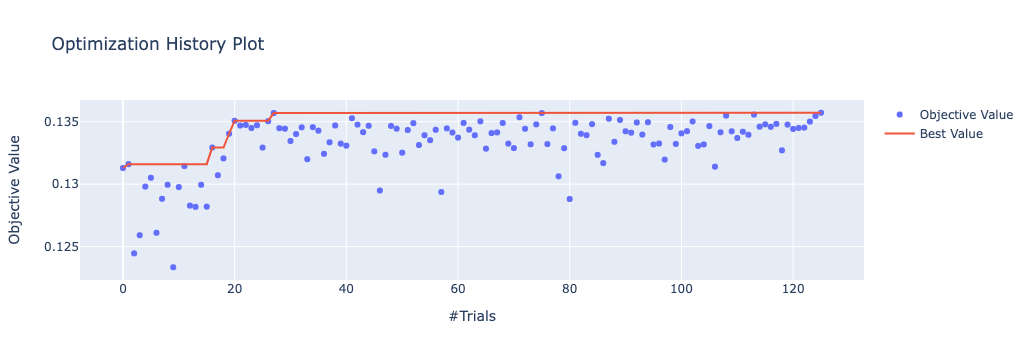

In [13]:
plot_optimization_history(study)

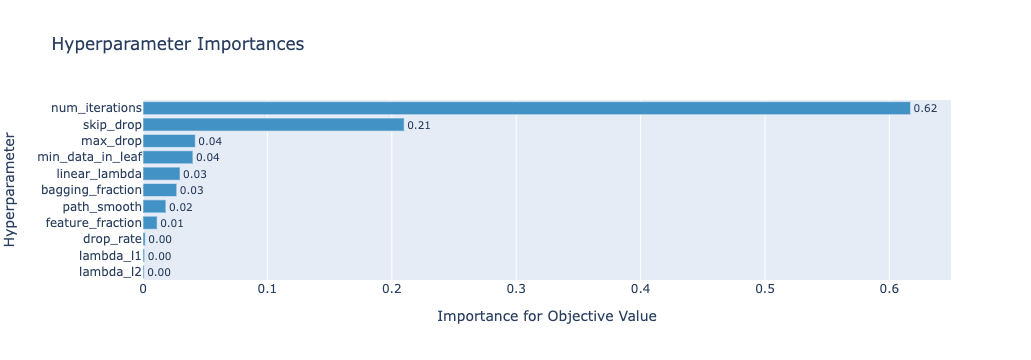

In [14]:
plot_param_importances(study)

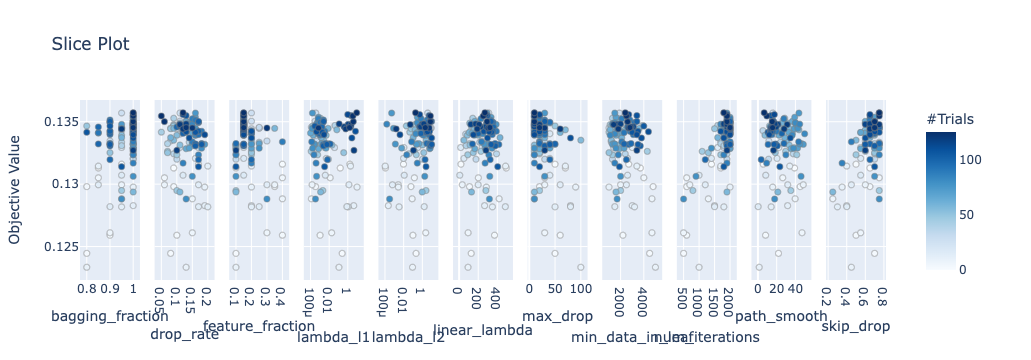

In [15]:
plot_slice(study)

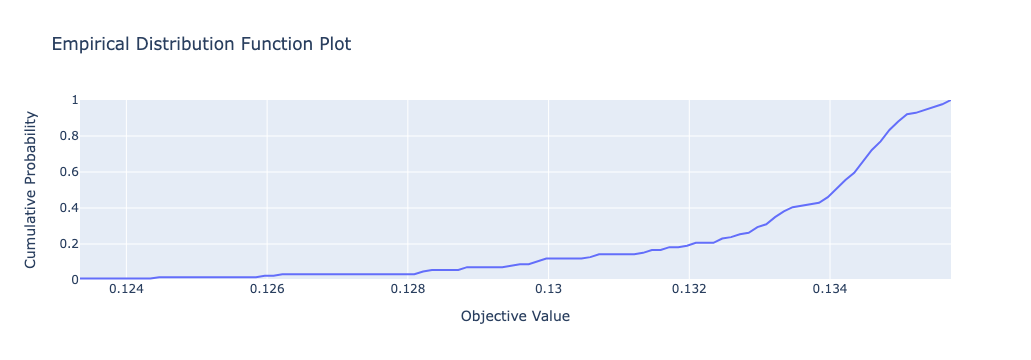

In [16]:
plot_edf(study)

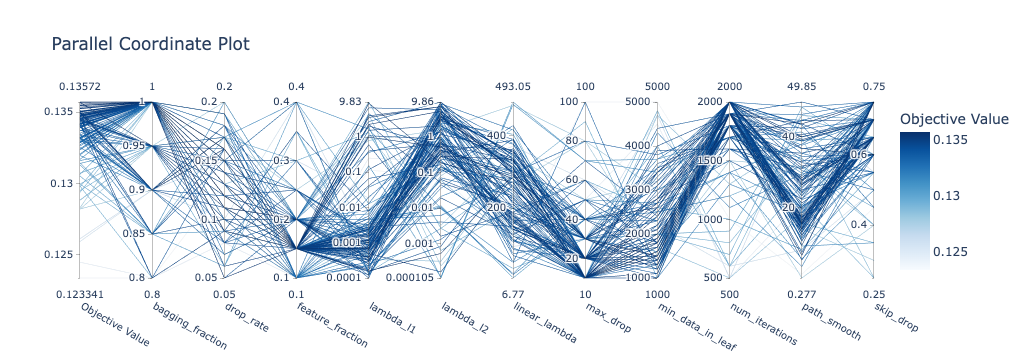

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params = {**default_params, **best_params}
best_params

{'boosting': 'dart',
 'linear_tree': True,
 'objective': 'mse',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'num_leaves': 32,
 'max_bin': 511,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 19,
 'verbosity': -1,
 'first_metric_only': False,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': False,
 'bagging_fraction': 1.0,
 'drop_rate': 0.12000000000000001,
 'feature_fraction': 0.15000000000000002,
 'lambda_l1': 9.088904851702456,
 'lambda_l2': 0.18748012338799666,
 'linear_lambda': 269.30765921686833,
 'max_drop': 10,
 'min_data_in_leaf': 2400,
 'num_iterations': 1800,
 'path_smooth': 6.67126050791083,
 'skip_drop': 0.75}

***